# Ungraded Lab: Data Augmentation

In the previous lessons, you saw that having a high training accuracy does not automatically mean having a good predictive model. It can still perform poorly on new data because it has overfit to the training set. In this lab, you will see how to avoid that using _data augmentation_. This increases the amount of training data by modifying the existing training data's properties. For example, in image data, you can apply different preprocessing techniques such as rotate, flip, shear, or zoom on your existing images so you can simulate other data that the model should also learn from. This way, the model would see more variety in the images during training so it will infer better on new, previously unseen data.

Let's see how you can do this in the following sections.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Baseline Performance

You will start with a model that's very effective at learning `Cats vs Dogs` without data augmentation. It's similar to the previous models that you have used. Note that there are four convolutional layers with 32, 64, 128 and 128 convolutions respectively. The code is basically the same from the previous lab so we won't go over the details step by step since you've already seen it before.

## Download and Inspect the Dataset

You can uncomment the line of code below to download the dataset to your notebook.

In [ ]:
#!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

You can run the following code to mount Google Drive in your Google Colab environment. This will allow you to access and work with files stored in your Google Drive directly from your Colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Access the path where the image dataset is located, and unzip it.

In [ ]:
import os
import zipfile # extract files .zip

# View current directory
print(f"The current path is: {os.getcwd()}")

# Path with cat and dog pictures
path_cats_dogs_pic = '/content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W2/Ungraded/Lab1'
os.chdir(path_cats_dogs_pic)
print(f"The new current path is: {path_cats_dogs_pic}")

# Unzip the files only if the Files folder exists and is a directory in the file system
zip_files = 'Files.zip'  # Name of the zip folder
unzip_files = 'Files/'   # Name of the unzip folder

if os.path.exists(unzip_files) and os.path.isdir(unzip_files):
  print(f"The folder '{unzip_files}' already exists and is a directory.")
else:
  print(f"The folder '{unzip_files}' does not exist or is not a directory.")
  print(f"Unzip Files...")
  zip_ref = zipfile.ZipFile(zip_files, 'r')
  zip_ref.extractall(unzip_files)
  zip_ref.close()

# View files
!ls

The current path is: /content/drive/My Drive/Tensorflow/DeepLearning.AI/C2/W2/Ungraded/Lab1
The new current path is: /content/drive/MyDrive/Tensorflow/DeepLearning.AI/C2/W2/Ungraded/Lab1
La carpeta 'Files/' ya existe y es un directorio.
C2_W2_Lab_1_cats_v_dogs_augmentation.ipynb  Files  Files.zip


In [ ]:
# Base Directory
BASE_DIR = os.path.join(os.getcwd(), 'Files/Files', 'cats_and_dogs_filtered')
print(f'Contents of base directory are: {os.listdir(BASE_DIR)}')

# Train and validation directory
train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')
print(f'Contents of training subdirectory are {os.listdir(train_dir)}')
print(f'validation subdirectory are {os.listdir(validation_dir)}')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Contents of base directory are: ['train', 'validation']
Contents of training subdirectory are ['dogs', 'cats']
validation subdirectory are ['dogs', 'cats']


You will place the model creation inside a function so you can easily initialize a new one when you use data augmentation later in this notebook.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import binary_crossentropy

class CatDogClassifier:
    def __init__(self):
        self.model = self.cnn_model()

    def cnn_model(self, cnn_filters=[32, 64, 128, 128]):
        '''Creates a CNN with four convolutional layers'''
        cnn_model = Sequential([
            Input(shape=(150, 150, 3)),
            Rescaling(1./255.0),
        ])
        for f in cnn_filters:
            cnn_model.add(Conv2D(filters=f, kernel_size=(3, 3), activation='relu'))
            cnn_model.add(MaxPooling2D(2, 2))
        cnn_model.add(Flatten())
        cnn_model.add(Dense(units=512, activation='relu'))
        cnn_model.add(Dense(units=1, activation='sigmoid'))
        return cnn_model

    def compile_model(self, optimizer=RMSprop, learning_rate=0.001, loss=binary_crossentropy, metrics=['accuracy']):
        self.model.compile(optimizer=optimizer(learning_rate=learning_rate), loss=loss, metrics=metrics)

    def summary(self):
        self.model.summary()

    def fit(self, train_dataset, epochs=15, validation_dataset=None, verbose=None):
        return self.model.fit(x=train_dataset, epochs=epochs, validation_data=validation_dataset, verbose=verbose)

You will preprocess the training and validation datasets as usual.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

def create_dataset(directory, image_size, batch_size=None, label_mode=None, optimizer_dataset=False, shuffle=False):
  # Optimize the datasets for training
  SHUFFLE_BUFFER_SIZE = 1000
  PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

  dataset =  image_dataset_from_directory(directory=directory, image_size=image_size, batch_size=batch_size, label_mode=label_mode)
  if optimizer_dataset:
    # Optimize the datasets for training
    dataset = dataset.cache() # Almacena en caché primero
    if shuffle:
      dataset.shuffle(SHUFFLE_BUFFER_SIZE) # Baraja si se especifica
    dataset.prefetch(PREFETCH_BUFFER_SIZE) # Realiza la operación de prefijad
  return dataset

# Optimize the datasets for training
train_dataset_final = create_dataset(train_dir, (150,150), 20, 'binary', True, True)
validation_dataset_final = create_dataset(validation_dir, (150,150), 20, 'binary', True, False)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


You will train only for 20 epochs to save time but feel free to increase this if you want.

In [ ]:
# Create an instance of the CatDogClassifier class.
classifier = CatDogClassifier()

# Compile the model
classifier.compile_model(optimizer=RMSprop, learning_rate=1e-4, loss=binary_crossentropy, metrics=['accuracy'])

# Show the model summary
classifier.summary()

# Train the model
history = classifier.fit(train_dataset=train_dataset_final, epochs=20, validation_dataset=validation_dataset_final, verbose=1)

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_17 (Rescaling)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_68 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_68 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_69 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_69 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_70 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_70 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_71 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.5179 - loss: 0.6922 - val_accuracy: 0.6010 - val_loss: 0.6835
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5658 - loss: 0.6809 - val_accuracy: 0.6100 - val_loss: 0.6606
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5832 - loss: 0.6638 - val_accuracy: 0.6280 - val_loss: 0.6443
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.6154 - loss: 0.6450 - val_accuracy: 0.6540 - val_loss: 0.6254
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.6503 - loss: 0.6180 - val_accuracy: 0.6820 - val_loss: 0.6008
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6866 - loss: 0.5865 - val_accuracy: 0.6940 - val_loss: 0.5817
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7096 - loss: 0.5605 - val_accuracy: 0.7000 - val_loss: 0.5699
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7180 - loss: 0.5388 - val_accu

You will then visualize the loss and accuracy with respect to the training and validation set. You will again use a convenience function so it can be reused later. This function accepts a History object which contains the results of the fit() method you ran above.

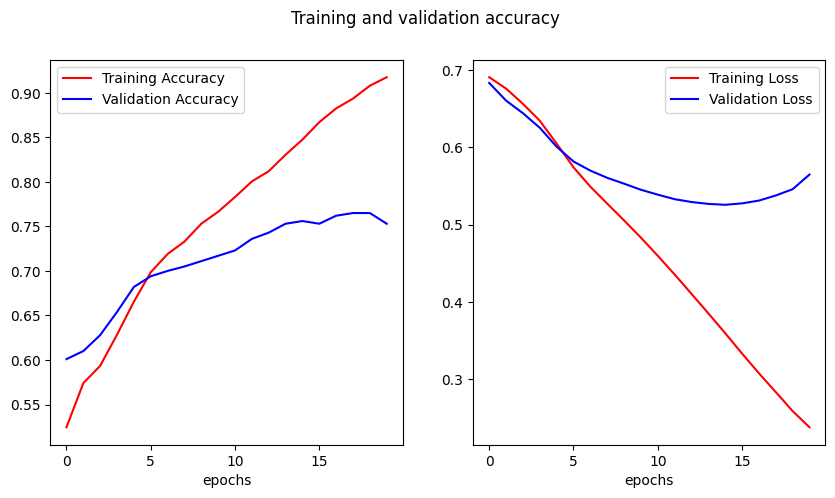

In [ ]:
import matplotlib.pyplot as plt

def plot_training_validation_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle('Training and validation accuracy')

    for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
        ax[i].plot(epochs, data[0], 'r', label="Training " + label)
        ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
        ax[i].legend()
        ax[i].set_xlabel('epochs')

    plt.show()

plot_training_validation_accuracy_loss(history)

From the results above, you'll see the training accuracy is more than 90%, and the validation accuracy is in the 70%-80% range. This is a great example of _overfitting_ -- which in short means that it can do very well with images it has seen before, but not so well with images it hasn't.

## Data augmentation

One simple method to avoid overfitting is to augment the images. If you think about it, most pictures of a cat are very similar -- the ears are at the top, the eyes are below the ears etc. Things like the distance between the eyes and ears will always be quite similar too.

What if you tweak with the images a bit -- rotate the image, squash it, etc.  That's what image augementation is all about.

To do that, you will build a data augmentation model with [preprocessing layers for image augmentation](https://www.tensorflow.org/guide/keras/preprocessing_layers#image_data_augmentation). This will transform the data during training to introduce variations of the same image. Let's quickly go over the layers you will use in this exercise.

* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) is for randomly flipping the images horizontally, vertically, or both.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation) rotates the image by an angle within a given range.
* [RandomTranslation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomTranslation) shifts pictures vertically and horizontally.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom) zooms into or out of the images.

In addition, some of these layers have a `fill_mode` parameter. This is the strategy used for filling newly created pixels, which can appear after a rotation or a width/height shift.

The code below will create this model with some set parameters. After you complete this lab, feel free to modify these and see the impact on the results.

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom

FILL_MODE = 'nearest'
random_flip_parameters = {"mode":'horizontal'}
random_rotation_parameters = {"factor":0.2, "fill_mode":FILL_MODE}
random_translation_parameters = {"height_factor":0.2, "width_factor":0.2, "fill_mode":FILL_MODE}
random_zoom_parameters = {"height_factor":0.2, "width_factor":None, "fill_mode":FILL_MODE}

def augmented_model(random_flip_pars={}, random_rotation_pars={}, random_translation_pars={}, random_zoom_pars={}):
        # Define fill mode.
        augmented_model = Sequential([
        # Specify the input shape.
        Input(shape=(150,150,3)),
        # Add the augmentation layers
        RandomFlip(mode=random_flip_pars["mode"]),
        RandomRotation(factor=random_rotation_pars["factor"], fill_mode=random_rotation_pars["fill_mode"]),
        RandomTranslation(height_factor=random_translation_pars["height_factor"], width_factor=random_translation_pars["width_factor"], fill_mode=random_translation_pars["fill_mode"]),
        RandomZoom(height_factor=random_zoom_pars["height_factor"], width_factor=random_zoom_pars["width_factor"], fill_mode=random_zoom_pars["fill_mode"]),
        ])
        return augmented_model

data_augmentation = augmented_model(random_flip_parameters, random_rotation_parameters, random_translation_parameters, random_zoom_parameters)

You will define a utility function that lets you preview how the transformed images look like. It will take in a sample image, then output a given number of augmented images using the model you defined above.

In [ ]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

Now get some images from the dataset.

In [ ]:
# Get a batch of images
sample_batch = list(train_dataset_final.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 20


This will show sample transformations for the first 4 images of the sample batch. Notice that each call of the `data_augmentation` model yields a different output. It's like adding more images to your dataset without you having to collect them manually.

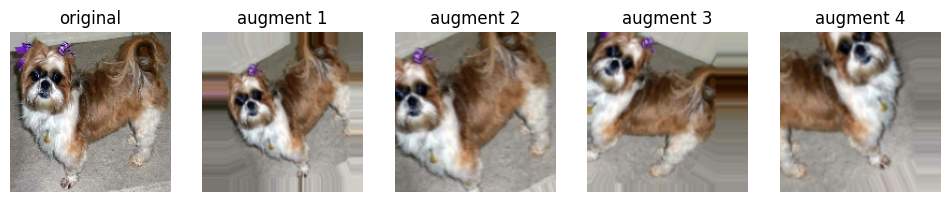

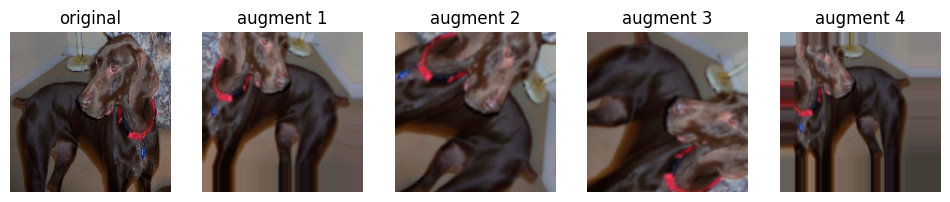

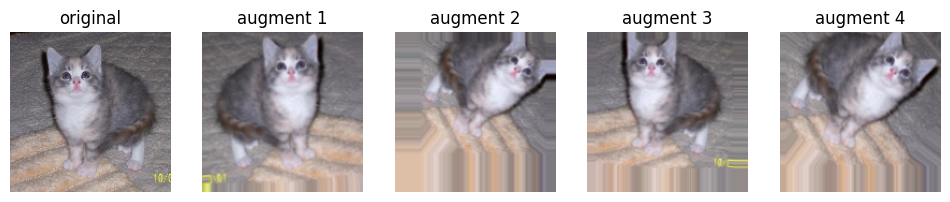

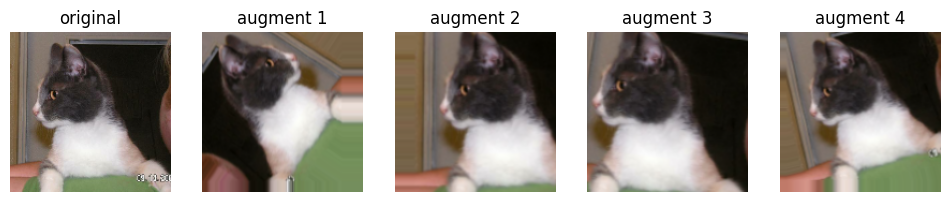

In [ ]:
NUM_AUG = 4

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# Uncomment the line below to delete the variable to free up some memory
# del sample_batch

Now that you see what the preprocessing layers do, you can prepend these to the base model so it can generate transformed images to the base model. Do note that these layers are only active while training. They are automatically disabled during prediction and evaluation.

Because you now have virtually more data, it will also take the model more time to learn the relevant features. Without data augmentation, your model already started overfitting to the training set within 20 epochs. Try training this model for 80 epochs and observe the results.

In [ ]:
# Instantiate the base model
model_without_aug = CatDogClassifier()

# Explorar el model sin aumentation y con aumentation
model_without_aug.summary()
data_augmentation.summary()

# Prepend the data augmentation layers to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug.model
])

# Compile the model
model_with_aug.compile(optimizer=RMSprop(learning_rate=1e-4), loss=binary_crossentropy, metrics=['accuracy'])

# Summary the model
model_with_aug.summary()

# Train the new model
history_with_aug = model_with_aug.fit(train_dataset_final, epochs=80, validation_data=validation_dataset_final, verbose=1)

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_18 (Rescaling)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_72 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_73 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_74 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_75 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 512)                 │       3,211,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_11 (RandomFlip)          │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_11 (RandomRotation)  │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_11                │ (None, 150, 150, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_11 (RandomZoom)          │ (None, 150, 150, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_40 (Sequential)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_41 (Sequential)           │ (None, 1)                   │       3,453,121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.5256 - loss: 0.6930 - val_accuracy: 0.5900 - val_loss: 0.6866
Epoch 2/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.5267 - loss: 0.6887 - val_accuracy: 0.5900 - val_loss: 0.6765
Epoch 3/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.5610 - loss: 0.6819 - val_accuracy: 0.5750 - val_loss: 0.6667
Epoch 4/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.5783 - loss: 0.6768 - val_accuracy: 0.5950 - val_loss: 0.6559
Epoch 5/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.5799 - loss: 0.6668 - val_accuracy: 0.6090 - val_loss: 0.6493
Epoch 6/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6259 - loss: 0.6502 - val_accuracy: 0.6140 - val_loss: 0.6430
Epoch 7/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.6093 - loss: 0.6525 - val_accuracy: 0.6370 - val_loss: 0.6242
Epoch 8/80
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.6272 - loss: 0.6342 - val_accu

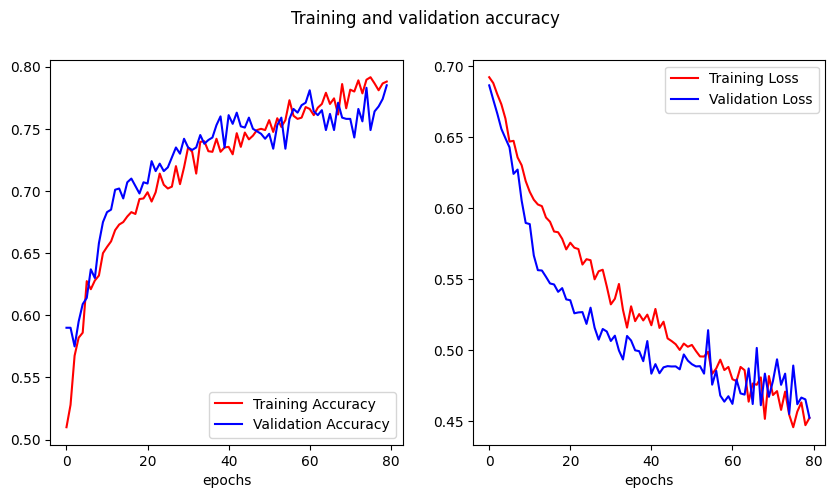

In [ ]:
plot_training_validation_accuracy_loss(history_with_aug)

As you can see, the training accuracy has gone down compared to the baseline. This is expected because (as a result of data augmentation) there are more variety in the images so the model will need more runs to learn from them. The good thing is the validation accuracy is no longer stalling and is more in line with the training results. This means that the model is now performing better on unseen data.

### Save the history

In [ ]:
import pickle
from google.colab import files

def download_history():
  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Wrap Up

This exercise showed a simple trick to avoid overfitting. You can improve your baseline results by simply tweaking the same images you have already. The image augmentation preprocessing layers will do just that. Try to modify the values in the augmentation model and see what results you get. You can also add other preprocessing layers for random contrast, brightness, or cropping.

Take note that this will not work for all cases. In the next lesson, Laurence will show a scenario where data augmentation will not help improve your validation accuracy.

Before going back to the classroom, run the cell below to free up resources for the next lab. You might see a pop-up about restarting the kernel afterwards. You can safely ignore it and just press Ok. You can then close this lab, then go back to the classroom for the next lecture. See you there!

In [ ]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)